<h1 style="text-align:center">Evaluation of Sentiment Analysis classifiers and News titles WebSrap</h1>
<h3>Motivation:</h3>
<p><b>News Sentiment Analysis</b> is one of the many applications for NLP, and the idea behind this notebook was to create a way of, automatically, create a news dataset by webscrapping data from different news web-sites and use existing classifiers to help/ classify each title.</p>
<h3>News titles sources:</h3>
<table >
    <tr>
        <th style="text-align:center">CNN</th>
        <th style="text-align:center">GoodNews Network</th>
    <tr>
    <tr>
        <td>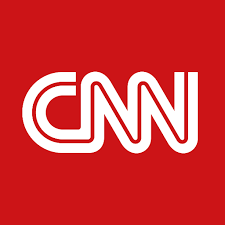</td>
        <td>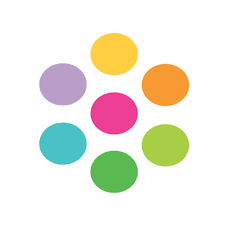</td>
    </tr>
</table>

<p><strong>CNN general news</strong></p>
<p><strong>GoodNews Network - general "positive" news</strong></p>


In [1]:
# 
import os
import csv
import time
# importing libraries
import pandas as pd
from bs4 import BeautifulSoup
import os


# Selenium
from selenium import webdriver   # for webdriver
from selenium.webdriver.support.ui import WebDriverWait  # for implicit and explict waits
from selenium.webdriver.chrome.options import Options  # for suppressing the browser


#nlp
import nltk
from nltk.corpus import stopwords
from string import punctuation
import unicodedata
import contractions
STOPWORDS = set(stopwords.words('english'))


#regular expressions
import re

# pretrained (sentiment classification)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# textBlob 
from textblob import TextBlob

# flair
import flair

# loop status viewer
from tqdm import tqdm


import warnings
warnings.filterwarnings(action='once')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/salvado/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2023-02-22 15:57:23.468159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 15:57:23.468181: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# set the driver
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
driver = webdriver.Chrome(options=options)

In [3]:
def goodnews_scrap(web='https://www.goodnewsnetwork.org/')-> list:
    
    driver.get(web)
    article_title = []
    soup_goodnews = BeautifulSoup(driver.page_source)
    news_list = soup_goodnews.find_all('div', class_='td-block-row')
    for news in news_list:
        for header in news.find_all('h3'):
            if len(header.get_text().split()) > 0:
                article_title.append(header.get_text())

    return article_title
    

In [5]:
def goodnews_scrap_v2(web='https://www.goodnewsnetwork.org/', n_articles = 10)-> list:
    """
        This function is to perform webscrap from the website Goodnews. This website is a website that
        will load more articles when one scrolldown. So we'll use Selenium to help us with that.
        We define also the number of articles we want to scrap.
        
    :param web: Goodnews WebSite 
    :param n_articles:  number of articles to scrap from the website  
    :return: list of headers from each article-
    """
    
    driver.get(web)
    screen_height = driver.execute_script('return window.screen.height;')  # get the height of one screen
    scrolling = True
    # for scrolling purposes
    scroll_init = 0
    i=0
    
    # init list article
    article_title = []
    
    while scrolling:
        driver.execute_script('window.scrollTo({scroll_init}, {screen_height});'.format(scroll_init=scroll_init, screen_height=screen_height))
        i += 1
        scroll_init = screen_height
        screen_height = scroll_init + screen_height
        time.sleep(2)
        
        soup_goodnews = BeautifulSoup(driver.page_source)
        news_list = soup_goodnews.find_all('div', class_='td-block-row')
        for news in news_list:
            for header in news.find_all('h3'):
                if len(header.get_text().split()) > 0:
                    article_title.append(header.get_text())
                    if len(article_title) > n_articles:
                        scrolling = False
                        break
                        
    return article_title

In [6]:
def cnn_scrap(web='https://edition.cnn.com/'):
    driver.get(web)
    soup_cnn = BeautifulSoup(driver.page_source)
    article_title = []
    for section in soup_cnn.find_all('section')[1:]:
        if len(section.find_all('ul')) > 0:
            for ul_elem in section.find_all('ul'):
                for elem in ul_elem.find_all('li'):
                    if len(elem.get_text().split()) > 0:
                        article_title.append(elem.get_text())
    return article_title

In [7]:
def cnn_scrapv2(web='https://edition.cnn.com/world'):
    """
        This function is to perform webscrap from the website CNN. This function is going to scrap each "layer",
        from the nav-bar on the top and the page "in it". (Africa, Europe, Americas, etc.)
        
    :param web: CNN World WebSite 
    :return: list of headers from each article-
    """
    driver.get(web)
    cnn_world = BeautifulSoup(driver.page_source)
    
    nav_items = cnn_world.find_all('div', class_='header__nav-item')
    #print(nav_items)
    url_list = []
    for url in nav_items:
        url_list.append(url.find('a')['data-zjs-destination_url'])
    article_title = []    
    for url in url_list:
        driver.get(url)
        page_soup = BeautifulSoup(driver.page_source)
        tmp = page_soup.find_all('section', class_='layout__wrapper')[0]
        for header in tmp.find_all('div', class_='container__headline'):
            if len(header.get_text().split()) > 0:
                article_title.append(header.get_text(strip=True))

    return article_title

In [8]:
goodnews = goodnews_scrap_v2(n_articles=400)
cnn = cnn_scrapv2()

print('Goodnews {}'.format(len(goodnews)))
print('CNN {}'.format(len(cnn)))

Goodnews 420
CNN 185


<p>Combine together the two lists of article headers</p>

In [9]:
titles_list = goodnews
titles_list.extend(cnn)
del goodnews
del cnn

<h3>Text preprocessing:</h3>
<ul>
    <li>remove accented characters from strings use UniDecode;  <b>check :D</b></li>
    <li>remove punctuation;  <b>check :D</b></li>
    <li>make everyword lowercase;  <b>check :D</b></li>
    <li>if present: remove the \n \t, etc from the strings;  <b>check :D</b></li>
    <li>try remove stopwords;  <b>check :D</b></li>
</ul>

In [10]:
def text_preprocessing(text: str, stop_word=True)-> str:
    """
    Function to preprocess text.
    """
    tmp = []
    for word in text.split():
        if word in list(contractions.contractions_dict.keys()):
            tmp.append(contractions.contractions_dict[word])
        elif re.findall(r"[A-Za-z]+"r"'"+r"[A-Za-z]", word):
            split_at = re.search(r"[']", word).span()[0]
            word = word[0:split_at]
            tmp.append(word)
        elif re.findall(r"[a-zA-z0-9]+"r"-"+r"[a-zA-z0-9]", word):
            l =re.split(r'-', word)
            tmp.extend(l)
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    text = text.translate(str.maketrans('','', punctuation))  # remove punctutations
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    if stop_word:
        text = [word for word in text.split() if word not in STOPWORDS]
        text = ' '.join(text)

    return text

<h3>Definition of the functions for each classifier.</h3>

In [11]:
def classify_text_vader(articles: list, dataframe_is_or_no=True)-> pd.DataFrame:
    """
        This function will classify text based on the Vader Intensity analyser.
        
    :param articles: list of titles
    :param dataframe_is_or_no:  to return a list of classification or Dataframe
    :return: list or DataFrame
    """
    DS = SentimentIntensityAnalyzer()
    articles_ = []
    article_class = []
    for article in tqdm(articles):
        text_original_classified = DS.polarity_scores(article)
        text_processed = text_preprocessing(article, False)
        text_processed_classified = DS.polarity_scores(text_processed)
        if dataframe_is_or_no:
            articles_.append([article, float(text_original_classified['compound']), text_processed, float(text_processed_classified['compound'])])
        else:
            article_class.append([text_original_classified['compound'], text_processed_classified['compound']])
    if dataframe_is_or_no:        
        return pd.DataFrame(articles_, columns=['Original', 'Original Sent', 'Processed', 'Processed Sent'])
    else:
        return article_class

In [12]:
def classify_text_Texblob(articles: list, dataframe_is_or_no=True)-> pd.DataFrame:
    """
        This function will classify text based on TextBlob analyser.
        
    :param articles: list of titles
    :param dataframe_is_or_no:  to return a list of classification or Dataframe
    :return: list or DataFrame
    """
    articles_ = []
    article_class = []
    for article in tqdm(articles):
        text_original_classified = TextBlob(article).sentiment
        text_processed = text_preprocessing(article, False)
        text_processed_classified = TextBlob(text_processed).sentiment
        if dataframe_is_or_no:
            articles_.append([article, float(text_original_classified[0]), text_processed, float(text_processed_classified[0])])
        else:
            article_class.append([text_original_classified[0], text_processed_classified[0]])
        
    if dataframe_is_or_no:        
        return pd.DataFrame(articles_, columns=['Original', 'Original Sent', 'Processed', 'Processed Sent'])
    else:
        return article_class

In [13]:
def clasify_text_flair(articles: list, dataframe_is_or_no=True)-> pd.DataFrame:
    """
        This function will classify text based on Flair analyser.
        
    :param articles: list of titles
    :param dataframe_is_or_no:  to return a list of classification or Dataframe
    :return: list or DataFrame
    """
    articles_ = []
    article_class = []
    flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
    for article in tqdm(articles):
        text_original_classified = flair.data.Sentence(article)
        flair_sentiment.predict(text_original_classified)
        sentiment_o = text_original_classified.score
        if re.findall('negative', str(text_original_classified.labels[0]), re.IGNORECASE):
            # print('not cool')
            sentiment_o = -1 * float(sentiment_o)

        text_processed = text_preprocessing(article, False)
        text_processed_classified = flair.data.Sentence(text_processed)
        flair_sentiment.predict(text_processed_classified)
        sentiment_p = text_processed_classified.score
        if re.findall('negative', str(text_processed_classified.labels[0]), re.IGNORECASE):
            # print('not cool')
            sentiment_p = -1 * float(sentiment_p)
        
        
        if dataframe_is_or_no:
            articles_.append([article, sentiment_o, text_processed, sentiment_p])
        else:
            article_class.append([sentiment_o, sentiment_p])
        
    if dataframe_is_or_no:        
        return pd.DataFrame(articles_, columns=['Original', 'Original Sent', 'Processed', 'Processed Sent'])
    else:
        return article_class  
    

<h3>Run each function of the titles list</h3>

In [14]:
vader_df = classify_text_vader(titles_list)
textblob_df = classify_text_Texblob(titles_list)
flair_df = clasify_text_flair(titles_list)
vader_df.shape, textblob_df.shape, flair_df.shape

100%|█████████████████████████████████████████| 605/605 [00:51<00:00, 11.76it/s]


((605, 4), (605, 4), (605, 4))

<h3>Result Dataframe</h3>

In [15]:
df_dict = {'Original':vader_df['Original'],
          'O_Vader': vader_df['Original Sent'],
          'O_TextBlob': textblob_df['Original Sent'],
          'O_Flair': flair_df['Original Sent'],
          'Processed':vader_df['Processed'], 
          'P_Vader':vader_df['Processed Sent'],
          'P_TextBlob': textblob_df['Processed Sent'],
          'P_Flair': flair_df['Processed Sent']}
df = pd.DataFrame.from_dict(df_dict)
df.head(2)

,Original,O_Vader,O_TextBlob,O_Flair,Processed,P_Vader,P_TextBlob,P_Flair
0,"Good News in History, February 22",0.4404,0.7,0.991240,good news in history february 22,0.4404,0.7,0.996779
1,Senior With No Car Walks to Work–But After She...,-0.2960,0.0,-0.923491,senior with no car walks to workbut after she ...,-0.2960,0.0,-0.994564


<h3>Time to use the information from all the 3 classifiers to create a final dataset.</h3>
<p>We are going to use the majority vote to classify all the articles titles.</p>
<p>Since none of these classifiers (not ML models except Flair) are "trained" specifically for the subjects in the titles specifically, we will try to use them together, the chance to have better results is higher. but we'll check that with labelled data.</p>
<p><b>(note: initially I had defined different intervals, but these ones "performed" i little better)</b></p>

<p>For the <strong>Vader Classification</strong>:</p>
<ul>
    <li>Negative : less than -0.5</li>
    <li>Neutral: -0.5 to 0.5</li>
    <li>Positive: more than 0.5</li>
</ul>

<p>For the <strong>TextBlob Classification</strong>:</p>
<ul>
    <li>Negative : less than -0.5</li>
    <li>Neutral: -0.5 to 0.5</li>
    <li>Positive: more than 0.5</li>
</ul>

<p>For the <strong>Flair Classification</strong>:</p>
<ul>
    <li>Negative : less than -0.5</li>
    <li>Neutral: -0.5 to 0.5</li>
    <li>Positive: more than 0.5</li>
</ul>




In [45]:
def majority_classification(dataframe: pd.DataFrame)-> pd.DataFrame:
    # original_columns = ['O_Vader', 'O_TextBlob', 'O_Flair', 'P_Vader', 'P_TextBlob', 'P_Flair' ]
    # withou Flair
    original_columns = ['O_Vader', 'O_TextBlob', 'P_Vader', 'P_TextBlob']
    punct = []
    for idx in dataframe.index:
        neg = 0
        neutral = 0
        pos = 0
        for column in original_columns:
            if dataframe[column][idx] < -0.5:
                neg += 1
                dataframe[column][idx] = 'negative'
            elif -0.5 <= dataframe[column][idx] <= 0.5:
                neutral += 1
                dataframe[column][idx] = 'neutral'
            elif dataframe[column][idx] > 0.5:
                pos += 1
                dataframe[column][idx] = 'positive'
        punct.append([neg, neutral, pos])
            
    return punct, dataframe

In [17]:
lista, dataframe = majority_classification(df)

/tmp/ipykernel_22404/2013728201.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column][idx] = 'neutral'


In [19]:
classification = ['negative', 'neutral', 'positive']
final = []
for ele in lista:
    if ele[0] == ele[1] and ele[0] == ele[2]:
        final.append('Nan')
    else:
        final.append(classification[np.array(ele).argmax()])
    
df['Classification'] = final
News_df_majority = df[['Original', 'Classification']]
News_df_majority.dropna(axis=0, inplace=True)

/tmp/ipykernel_22404/2393953630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  News_df_majority.dropna(axis=0, inplace=True)


In [20]:
News_df_majority.head()

,Original,Classification
0,"Good News in History, February 22",positive
1,Senior With No Car Walks to Work–But After She...,neutral
2,Dutch Woman Smashes a World Record Unbroken Fo...,neutral
3,MDMA and Psilocybin-Assised Psychotherapy Appr...,neutral
4,First of Its Kind Discovery in Mali: Vast Rese...,positive


<h3>To evaluate if this method for creating a news Title dataset is at least, anygood, we'll use labelled data from Kaggle to try it out.</h3>

In [21]:
financial = pd.read_csv('kaggle_data/all-data.csv',delimiter=',', encoding='latin-1', header=None).fillna('')
y = financial[0]
x = financial[1]

In [22]:
vader_df = classify_text_vader(x)
textblob_df = classify_text_Texblob(x)
flair_df = clasify_text_flair(x)
# vader_df.shape, textblob_df.shape, flair_df.shape

100%|███████████████████████████████████████| 4846/4846 [07:43<00:00, 10.45it/s]


In [44]:
df_dict = {'Original':vader_df['Original'],
          'O_Vader': vader_df['Original Sent'],
          'O_TextBlob': textblob_df['Original Sent'],
           'O_Flair': flair_df['Original Sent'],
          'Processed':vader_df['Processed'], 
          'P_Vader':vader_df['Processed Sent'],
          'P_TextBlob': textblob_df['Processed Sent'],
           'P_Flair': flair_df['Processed Sent']
          }

# without Flair because it performed poorly
df_dict = {'Original':vader_df['Original'],
          'O_Vader': vader_df['Original Sent'],
          'O_TextBlob': textblob_df['Original Sent'],
          'Processed':vader_df['Processed'], 
          'P_Vader':vader_df['Processed Sent'],
          'P_TextBlob': textblob_df['Processed Sent'],
          }

df = pd.DataFrame.from_dict(df_dict)
df.head(5)

,Original,O_Vader,O_TextBlob,Processed,P_Vader,P_TextBlob
0,"According to Gran , the company has no plans t...",-0.1280,0.000000,according to gran the company has no plans to...,-0.1280,0.000000
1,Technopolis plans to develop in stages an area...,-0.2960,0.083333,technopolis plans to develop in stages an area...,-0.2960,0.083333
2,The international electronic industry company ...,0.0000,0.000000,the international electronic industry company ...,0.0000,0.000000
3,With the new production plant the company woul...,0.8555,-0.064802,with the new production plant the company woul...,0.8555,-0.064802
4,According to the company 's updated strategy f...,0.6705,0.000000,according to the company s updated strategy fo...,0.6705,-0.016667


In [46]:
lista, dataframe = majority_classification(df)

/tmp/ipykernel_22404/4016931059.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column][idx] = 'neutral'


In [47]:
y_vader = dataframe['P_Vader']
y_textblob = dataframe['P_TextBlob']
#y_flair = dataframe['P_Flair']

In [48]:
classification = ['negative', 'neutral', 'positive']
final = []
for ele in lista:
    if ele[0] == ele[1] and ele[0] == ele[2]:
        final.append('Nan')
    else:
        final.append(classification[np.array(ele).argmax()])
    
df['Classification'] = final
News_df = df[['Original', 'Classification']]
News_df.dropna(axis=0,inplace=True)

/tmp/ipykernel_22404/1713618693.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  News_df.dropna(axis=0,inplace=True)


In [49]:
y_pred = News_df['Classification']


In [50]:
from sklearn.metrics import classification_report, accuracy_score
print(accuracy_score(y, y_pred))

0.6004952538175815


              precision    recall  f1-score   support

    negative       0.47      0.07      0.12       604
     neutral       0.60      0.98      0.75      2879
    positive       0.65      0.03      0.05      1363

    accuracy                           0.60      4846
   macro avg       0.58      0.36      0.31      4846
    weighted avg       0.60      0.60      0.47      4846


<h3>This method didn't perform very well and that was expected, because of the nature of the "classifiers"</h3>
<p>This is why, according to subject, we train/ develop specific models. However, it was a good exercise.</p>